In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

# Improving on OLS

When we introduced regression, we said that the model fit is determined by minimizing the sum of the squared differences between the predicted and actual values. This is _Ordinary Least Squares_:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$$

It just so happens, however, that we can get more accurate *predictions* by modifying this cost function in various ways.  One way to think of this is that the OLS cost function optimizes variance explained *in the training set.*  Ridge and lasso regressions are two examples of modifying this cost function. They lead to models that optimize variance explained *in the test sets.*  Generally our goal is to make a model that tells us about the world (and not just our training sample), so ridge and lasso solutions are useful.

# Ridge regression

**Ridge regression** minimizes this cost function:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$

Comparing this cost function to the OLS cost function above, you can see it consists of the OLS function with a new part to the right:

$$\lambda\sum_{j=1}^p\beta_j^2 $$

This new part imposes a penalty for large coefficients.  It represents the sum of the square of all model coefficients (numbered 1 through $p$), multiplied by the regularization parameter $\lambda$.  As $\lambda$ gets larger, the penalty for coefficient size also gets larger, and the solution that minimizes the cost function will by necessity have smaller coefficient estimates.  Regularization based on the sum of the squared weights is also called "**L2 regularization**".

[**Quick check**: If the convention is to call the regularization parameter "*lambda*" ($\lambda$), why does SKlearn call it "*alpha*"?  Hint: It's the same reason why you shouldn't name your own variables in Python things like "mean".]

The core principle behind ridge regression is that, as models become increasingly complex and features correlate with one another more and more (become _multicolinear_), coefficients arrived at by OLS become increasingly large. This is a sign that the model is incorporating too much variance from the dataset – in other words, overfitting. Ridge regression is a model variance minimizer and works to keep that from happening. For a deep dive into the underlying math and origin of the term "ridge regression" see this detailed [Stack Exchange answer](http://stats.stackexchange.com/questions/151304/why-is-ridge-regression-called-ridge-why-is-it-needed-and-what-happens-when).

Here's an example of coefficient inflation, using some patterns of defaulting on credit accounts. You can [read more about this data here](http://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Default.html).

First, we'll build an OLS multivariate linear regression model predicting defaults using all the features in the data. Then, we'll create some new correlated features, add them to the model, and see what that does to the size of the original coefficients.

Standardizing data? 
https://www.youtube.com/watch?v=sh_tLn1phfc&ab_channel=KateMaurer

What is -1 in np.reshape ?
https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

In [2]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
#TGA: wondering what values we obtain when standarizing binary values
# see the two lines below
print("zscore for defaults = 0: ", (0 - df['default'].mean())/df['default'].std())
print("zscore for defaults = 1: ", (1 - df['default'].mean())/df['default'].std())

df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
# TGA: copy: shallow copy
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

#print(df_test.shape)
#print(df_train.shape)

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))


# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0, 0:(len(origparams) - 1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

zscore for defaults = 0:  -0.18558998712925542
zscore for defaults = 1:  5.387682899635171

R-squared simple model:
0.5738784962717032

R-squared complex model:
0.5739734452075469

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.866]
 [-0.001 553434.559]]


Look at that intercept (last line)!  The R-squared value barely increased, but even so the inflation of the parameters suggests that the gain is due to overfitting.  Let's apply the model to the test set and find out:

In [3]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.5630697922503316

R-squared complex model:
0.5630239527334708


Yup- the more complex model actually fits worse.  The differences here are quite small, but that isn't always the case.  What happens if we apply ridge regression to this situation?

Mean Centered data has a y intercept of 0: https://www.youtube.com/watch?v=L9kQlZyBK3Q&ab_channel=BurkeyAcademy

In [4]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
# 3 features
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
# select only the first four features(including the intercept)
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613458

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


For a detailed discussion of why the intercept is not regularized, see [this entry on Stack Exchange](http://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression).

The difference in magnitude for parameters in the training set is much smaller – no parameter explosion here. Let's check the implications for the fit of the models on the test set.

In [5]:
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.5631088763076704
0.5631804323930644


And now, the model that worked a little better on the training set also works a little better on the test set. Again, these differences are small and don't matter much here, but in real life much larger differences can happen. Ridge regression is an excellent tool to reach for whenever you have many correlated parameters, or when you start to see parameter estimates inflate as the R-square estimate goes up, suggesting overfitting.

## Regularization parameter: Ridge

Earlier, we set the regularization parameter $\lambda=10$.  In ridge regression, the regularization parameter $\lambda$ can take any value greater than 0.  The best way to choose an optimal regularization parameter is through cross-validation, checking which parameter gives the most consistent results across training and test sets.  Here is an illustration of how the parameter values in the income model vary as alpha goes up.

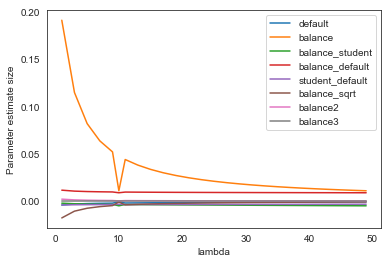

In [8]:
# Store estimates.
# (9 of them) 3 + 6
# 10 the value of lambda which led to the 9 weights
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    # append a new list to the collection of lists
    # As the end of this loop 25 new lists will be added
    # so totally the list will have 26 lists
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))
# returns (26,10)
# estimates.shape

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
#estimates_df
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    # plot a line
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
# list of labels
plt.legend(labels)
plt.show()

For a truly deep-dive into the math behind ridge regression, check out these lecture slides on [Ridge Regression](http://www.few.vu.nl/~wvanwie/Courses/HighdimensionalDataAnalysis/WNvanWieringen_HDDA_Lecture23_RidgeRegression_20172018.pdf).

#### Reflection

Multicolinearity creates problem in regression. We try to remove correlated features or combine them, but it is not possible to do that always. In this notebook, We proved that multicolinearity is expressed through the cofficients of a regression model. 
Large coffcients = Multicolinearity. 

Multicolinearity and large coffients also led to overfitting. A hero on a training set can be zero on the test set. Despite we observed small discrepancies here, in real life the difference between test error and training error can be large.

Adding the L2 norm to the OLS cost function will penalize the model forcing it to learn smaller coffciencts

Lambda controls the amount of penality applied to the model. Very large lambda will create a model which has high bias, a model which performs bad. A very small lambda will be close to an overfitting model.


On this notebook

(OLS)

            Small features      Many Correlated Features

                                Winner on the train set                    

            Winner on test set         


(Ridge, lambda = 10)

            Small features      Many Correlated Features

                                Winner on train set                 

                                Winner on test set                    


On the Polynomial Regression notebook
A complex model is compared to a its regularaized version


            alpha = 0              alpha = 0.055

            Winner on train set

                                   Winner on test set